# DEA CoastLines utility functions

## Load modules/functions


In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd 
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles
from shapely.geometry import box
import matplotlib.colors as colors

from owslib.wms import WebMapService
import subprocess
import xarray as xr
import os
import uuid

import pandas as pd
from IPython.display import display


def wms_layers_styles(url):
    
    # Get WMS data from URL
    wms_items = dict(WebMapService(url, version='1.3.0').items())
    
    return wms_items
    layers_styles = {key: val.styles.keys() for key, val in wms_items.items()}

    # Create a dataframe with an index of layer names and list of styles
    layers_df = pd.DataFrame(index=layers_styles.keys())
    layers_df['styles'] = layers_styles.values()
    layers_df.index.name = 'layer'
    
    # Print output
    with pd.option_context('display.max_rows', None, 
                           'display.max_colwidth', 255):
        display(layers_df)
    
    return layers_df


def wms_xarray(url, 
               layer, 
               bbox, 
               layerstyle, 
               layertime,                
               layerformat='png', 
               layersizex=512, 
               layersizey=512,
               epsg='EPSG:4326'):

    # Get extent
    y_max, x_min, y_min, x_max = bbox

    # Create tempory path files
    unique_id = str(uuid.uuid4())
    infile = f'{unique_id}.tif'
    outfile = f'{unique_id}_georef.tif'

    wms = WebMapService(url, version='1.3.0')
    crs = sorted(wms[layer].crsOptions)
    time = wms[layer].timepositions
    
    output = wms.getmap(layers=[layer],
                styles=[layerstyle],
                srs='EPSG:4326',
                bbox=(x_min, y_min, x_max, y_max),
                size=(layersizex, layersizey),
                format='image/'+layerformat,
                time=layertime
                )
            
    with open(infile, 'wb') as out:
        out.write(output.read())   
   
    # TODO write as python rather than system call
    subprocess.call(['gdal_translate','-a_srs', epsg, 
                     '-a_ullr', str(x_min), str(y_max), str(x_max), str(y_min), 
                     infile, outfile])
    ds = xr.open_rasterio(outfile)
    
    # Remove temporary rasters
    os.remove(outfile)
    os.remove(infile)
    
    return(ds)



def rates_hist(stats_path, 
               extent_path=None,
               cmap='RdBu',
               hist_log=True, 
               hist_bins=60, 
               hist_range=(-30, 30),
               export_figure=None):
    """
    Function for analysing DEACoastLines statistics point data, plotting 
    resules as histograms to compare rates of change.
    
    Parameters
    ----------
    stats_path : string
        Path to DEACoastLines statistics point vector file (e.g. 
        DEACoastLines_statistics_ntwa.shp')
    extent_path : string, optional
        An optional path to a shapefile or other vector file that will be used
        to extract a subset of DEACoastLines statistics. The default is None,
        which will select a subset of data using an interactive map.
    hist_log : boolean, optional
        An optional boolean indicating whether to plot histograms with a log 
        y-axis. If True, all non-significant statistics points will be assigned
        a rate of 0 metres / year. If False, all non-significant points will 
        be removed from the dataset, and plotted with a linear y-axis.    
    export_figure : string, optional
        An optional string giving the file path to export the output figure to
        as an image. The default is None, which will not export an image.
    """
    
    if extent_path:
        extent = gpd.read_file(extent_path)

    else:
        # Plot interactive map to select area
        basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
        geopolygon = select_on_a_map(height='600px',
                                     layers=(basemap,),
                                     center=(-26, 135), 
                                     zoom=4) 

        # Covert extent object to geopandas.GeoSeries object with CRS
        extent = box(*geopolygon.boundingbox)
        extent = gpd.GeoSeries(extent, crs='EPSG:4326')

    # Extract corresponding portion of stats file
    print('Extracting point statistics data')
    stats_subset = gpd.read_file(stats_path, bbox=extent)
    
    # Raise exception if no points are returned
    if len(stats_subset.index) == 0:
        raise ValueError('No statistics points were returned for the supplied '
                         'extent. Please select another area, or specify a '
                         'points statistics file that covers the area you are '
                         'interested in.')

    if hist_log:

        print('Plotting data with log axis after setting non-significant points to 0 m / year')
        stats_subset.loc[stats_subset.sig_time > 0.01, 'rate_time'] = 0
        bin_offset = (hist_range[1] - hist_range[0]) / (hist_bins / 0.5)

    else:
        print('Plotting data with linear axis after filtering to significant values')
        stats_subset = stats_subset.loc[stats_subset.sig_time < 0.01]
        bin_offset = 0

    # Select colormap
    cm = plt.cm.get_cmap(cmap)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    ax1.grid(True, which="both", axis='y', color='0.9')
    ax1.set_axisbelow(True)

    # Plot histogram    
    n, bins, patches = ax1.hist(stats_subset.rate_time, 
                                bins=hist_bins, 
                                range=[(a + bin_offset) for a in hist_range], 
                                log=hist_log,
                                edgecolor='black')

    # Scale values to interval [0,1]
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    norm = colors.SymLogNorm(linthresh=0.25, 
                             linscale=0.05,
                             vmin=hist_range[0], 
                             vmax=hist_range[1], 
                             base=10)
    col = norm(bin_centers)  

    # Apply colors to bars
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

    ax1.set_title(f'Mean rate: {stats_subset.rate_time.mean():.2f} m / year')
    ax1.set_xlabel('Rate of change (m / year)')
    ax1.set_ylabel('Frequency')
    
    minx, miny, maxx, maxy = stats_subset.to_crs('epsg:4326').total_bounds
    midx = (minx + maxx) / 2.0
    midy = (miny + maxy) / 2.0
    width_r = (maxx - minx) / 2.0
    height_r = (maxy - miny) / 2.0
    radius = max(width_r, height_r)
    wms_extent = [midy + radius, midx - radius, midy - radius, midx + radius]
    
    ds = wms_xarray(url="https://gsky.nci.org.au/ows/dea",  #WMS for background image
                    layer="landsat8_geomedian",  #WMS layer name
                    bbox=wms_extent, 
                    layerstyle='tc',
                    layertime='2018-01-01T00:00:00.000Z')
    ds.isel(band=[0, 1, 2]).plot.imshow(ax=ax2, 
                                        alpha=0.3, 
                                        add_labels=False)  
    
    ax2.set_title('DEACoastLines statistics points')
    
    # Plot vector points
    stats_subset = (stats_subset
                    .to_crs('EPSG:4326')
                    .reindex(stats_subset
                             .rate_time.abs()
                             .sort_values(ascending=True).index))
    stats_subset.plot(ax=ax2, 
                      column='rate_time', 
                      norm=norm, 
                      cmap=cmap, 
                      edgecolor='0.8',
                      linewidth=0.2,
                      markersize=20) 
    
    # Optionally export figure
    if export_figure:
        print(f'Exporting figure to {export_figure}')
        plt.savefig(export_figure, bbox_inches='tight')
    
    return ds
    


## Histogram analysis



Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Extracting point statistics data
Plotting data with linear axis after filtering to significant values
Exporting figure to output.png


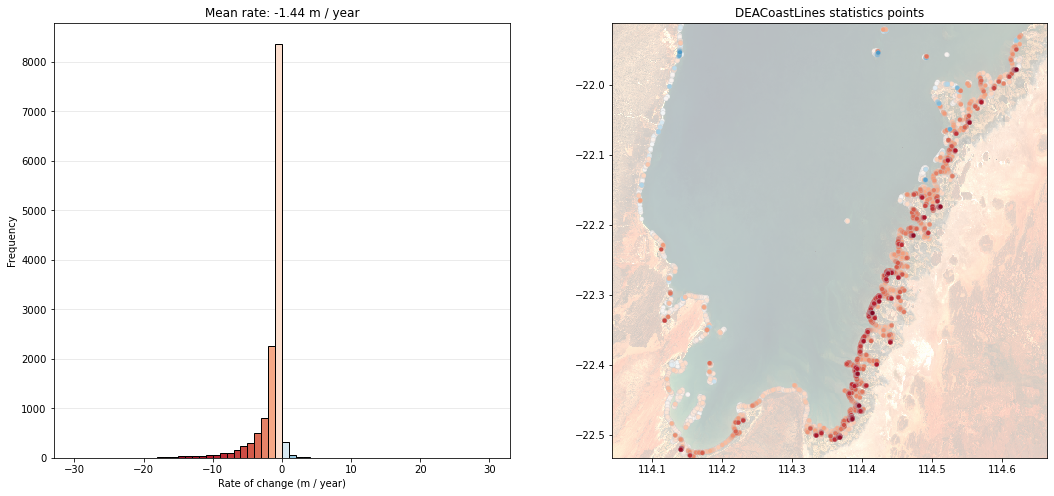

In [2]:
stats_path='/g/data/r78/rt1527/dea-notebooks/MAHTS/DEACoastLines_statistics_ntwa.shp'
# stats_path='/g/data/r78/rt1527/dea-notebooks/MAHTS/DEACoastLines_statistics_nswqld.shp'
# stats_path='/g/data/r78/rt1527/dea-notebooks/MAHTS/DEACoastLines_statistics_tasvicsa.shp'

ds = rates_hist(stats_path=stats_path, 
                hist_log=False,
                export_figure='output.png') 

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** March 2020